In [ ]:
!pip install bayesian_testing

  Obtaining dependency information for bayesian_testing from https://files.pythonhosted.org/packages/3d/eb/4fdef7c5ea0ad9bb560931b871d4b47559498b251fa15eae0823826d0b61/bayesian_testing-0.6.2-py3-none-any.whl.metadata


# Bayesian Testing for Conversion Rates

### Input the number of conversions and total number of impressions

This will run 100k random samples using this data to estimate a probability density function.

### Output the probability of treatment performing better than control

Note: since this is using random sampling, the probability will change slightly each time it's run.

In [152]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

#this is using random sampling
#fill out conversions, 23, and no conversions (sample size for variant), 500
#num_pair_samples is times it will do random sampling for beta distribution
num_pair_samples = 100000
a_conv = 2052
a_no_conv = 270897 - a_conv

b_conv = 2187
b_no_conv = 274833 - b_conv

a_rate = a_conv / (a_conv+a_no_conv)
b_rate = b_conv / (b_conv+b_no_conv)

a_samples = stats.beta.rvs(a_conv, a_no_conv, size =num_pair_samples)
b_samples = stats.beta.rvs(b_conv, b_no_conv, size =num_pair_samples)
#beta is the probabiliy density function

wins = b_samples>a_samples
np.mean(wins)

0.94645

# Using the Bayesian Testing package to do a similar calculation

### Input the number of conversions and total impressions (using the same as above here)

BinaryDataTest is used for conversions (i.e., 0: did not convert, 1: did convert).

Commented out code allows for a conversion rate instead of raw conversions and impressions.

### Output the conversion rate and probability that treatment performs better than control.

Note this number may not match exactly the number above since these both use random sampling.

In [87]:
#https://towardsdatascience.com/python-package-for-bayesian-a-b-testing-86ea3ff5c963
#https://pypi.org/project/bayesian-testing/
#can do binary for conversion, deltalognormal for revenue
#normaldatatest for height, discrete data test for categorical/rating


#Conversion Test (binary data)

from bayesian_testing.experiments import BinaryDataTest

#initialize test
conv_test = BinaryDataTest()

#add variant using aggregated data (same as raw data with 950 zeros and 50 ones)
#conv_test.add_variant_data_agg("C", totals=1000,positives=32)
conv_test.add_variant_data_agg("A", totals=a_conv + a_no_conv,positives=a_conv)
conv_test.add_variant_data_agg("B", totals=b_conv + b_no_conv,positives=b_conv)


conv_test.evaluate()

#For Raw Data and random sampling
#a has 5.2% probability of successful conversion
#p = conversion rate
#size = samples
# rng=np.random.default_rng(100)
# a_data = rng.binomial(n=1, p=0.023, size=1000)
# b_data = rng.binomial(n=1, p=0.027, size=1000)

#add variant using raw data (arrays of zeros and ones)
# conv_test.add_variant_data("A", a_data)
# conv_test.add_variant_data("B",b_data)
#note: you can add priors, but default for this test is a=b=1/2
#test.add_variant_data("B",b_data,a_prior=1,b_prior=20)

[{'variant': 'A',
  'totals': 270897,
  'positives': 2052,
  'positive_rate': 0.00757,
  'posterior_mean': 0.00758,
  'prob_being_best': 0.0533,
  'expected_loss': 0.0003866},
 {'variant': 'B',
  'totals': 274833,
  'positives': 2187,
  'positive_rate': 0.00796,
  'posterior_mean': 0.00796,
  'prob_being_best': 0.9467,
  'expected_loss': 5.4e-06}]

### The 95% confidence intervals for each variant

In [97]:
#95% confidence interval for conversion rate of a_samples
a_samples_lower = np.percentile(a_samples, 2.5)
a_samples_upper = np.percentile(a_samples, 97.5)
print(np.round(a_samples_lower,5))
print(np.round(a_samples_upper,5))

0.00725
0.0079


In [98]:
#95% confidence interval for conversion rate of b_samples
b_samples_lower = np.percentile(b_samples, 2.5)
b_samples_upper = np.percentile(b_samples, 97.5)
print(np.round(b_samples_lower,5))
print(np.round(b_samples_upper,5))

0.00763
0.00829


### Visualize the probability density functions for each variant

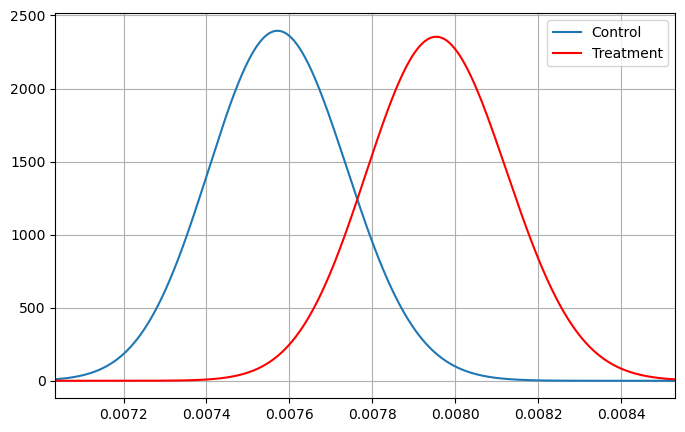

In [153]:
fig, ax = plt.subplots(figsize=(8,5))
#linspace returns evenly spaced numbers over a specified interval
x = np.linspace(.0,.01, num=5000)
#beta.pdf is the probability density function
# plot(x,y) - the x is making the x-axis look at 0 to 1
ax.plot(np.linspace(0, .01, 5000), stats.beta.pdf(x,a_conv,a_no_conv), label='Control')
ax.plot(np.linspace(0, .01, 5000), stats.beta.pdf(x,b_conv,b_no_conv), color='red', label='Treatment')
ax.set_xlim(np.percentile(a_samples, .05),np.percentile(b_samples, 99.95))
plt.legend()
plt.grid()

## Visualize probability that treatment is better than control
Look at the Area under the curve

In [154]:
#generate random numbers
np.set_printoptions(precision=5)
a_rvs = stats.beta.rvs(a=a_conv, b=a_no_conv, size=10)
print(a_rvs)

b_rvs = stats.beta.rvs(a=b_conv, b=b_no_conv, size=10)
print(b_rvs)

[0.00752 0.00763 0.00759 0.00736 0.00757 0.00773 0.00721 0.00753 0.00787
 0.00743]
[0.00808 0.00794 0.008   0.00775 0.00814 0.00798 0.00818 0.00766 0.0082
 0.00811]


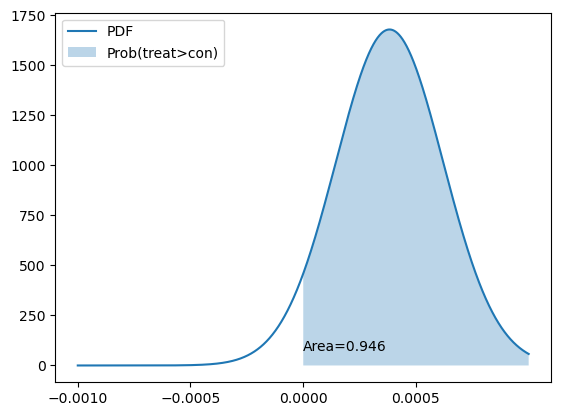

In [156]:
#plot
#p = norm(rate_b - rate_a, np.sqrt(std_a**2 + std_b**2))
std_a = stats.beta.std(a_conv, a_no_conv, loc=0, scale=1)
std_b = stats.beta.std(b_conv, b_no_conv, loc=0, scale=1)

x = np.linspace(-.001,0.001,num=5000)
p = stats.norm(b_rate - a_rate, np.sqrt(std_a**2 + std_b**2))
y = p.pdf(x)

#get 1 - p-value for 1-tail test, probability treatment is better than control
area_under_curve = p.sf(0)
plt.plot(x,y, label="PDF", )
plt.xticks(np.arange(-.001,0.001, step=.0005))
plt.fill_between(x, 0, y, where=x>0, label="Prob(treat>con)", alpha = 0.3)
plt.annotate(f"Area={area_under_curve:0.3f}",(0,75))
plt.legend()


# Using DeltaLognormalDataTest for non-zero values

When you have positive values, like revenue can have $0, $1.83, $3.60, etc. per session, use deltalognormal.

### Input arrays of data for each variant. These must be positive numbers

### Output probability of treatment performing better than control

In [81]:
import numpy as np
from bayesian_testing.experiments import DeltaLognormalDataTest


#Revenue Test. Revenue per session data where many session have 0 revenue but non-zero values are positive numbers with possible log-normal distribution
#Combines binary Bayes model for zero vs non-zero "conversions" and log-normal model for non-zero values
rev_test = DeltaLognormalDataTest()

data_a = [7.1, 0.3, 5.9, 0, 1.3, 0.3, 0, 1.2, 0, 3.6, 0, 1.5, 2.2, 0, 4.9, 0, 0, 1.1, 0, 0, 7.1, 0, 6.9, 0]
data_b = [4.0, 0, 3.3, 19.3, 18.5, 0, 0, 0, 12.9, 0, 0, 0, 10.2, 0, 0, 23.1, 0, 3.7, 0, 0, 11.3, 10.0, 0, 18.3, 12.1]

# adding variant using raw data:
rev_test.add_variant_data("A", data_a)
# test.add_variant_data("B", data_b)

# alternatively, variant can be also added using aggregated data:
# (looks more complicated but for large data it can be quite handy to move around only these sums)
rev_test.add_variant_data_agg(
    name="B",
    totals=len(data_b),
    positives=sum(x > 0 for x in data_b),
    sum_values=sum(data_b),
    sum_logs=sum([np.log(x) for x in data_b if x > 0]),
    sum_logs_2=sum([np.square(np.log(x)) for x in data_b if x > 0])
)

# evaluate test:
rev_test.evaluate(seed=21)

[{'variant': 'A',
  'totals': 24,
  'positives': 13,
  'sum_values': 43.4,
  'avg_values': 1.80833,
  'avg_positive_values': 3.33846,
  'prob_being_best': 0.04815,
  'expected_loss': 4.0941101},
 {'variant': 'B',
  'totals': 25,
  'positives': 12,
  'sum_values': 146.7,
  'avg_values': 5.868,
  'avg_positive_values': 12.225,
  'prob_being_best': 0.95185,
  'expected_loss': 0.1588627}]

# Visual Explanation for Bayesian Prior Distribution

Start with a prior distribution - as you gather more data, you update this distribution to a post distribution.


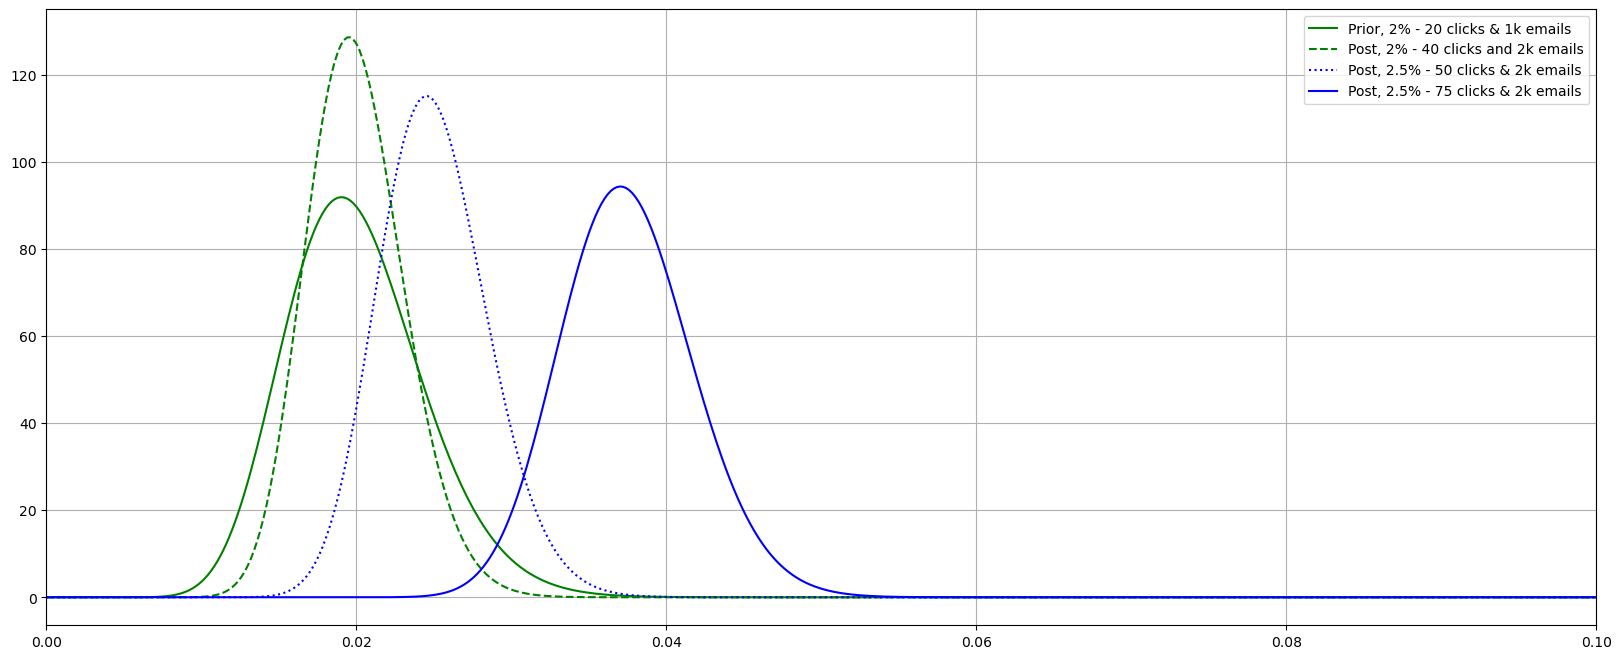

In [93]:
# plot(x,y) --> x is for x-axis 0 to 1
# plot(x,y) --> y is for beta distribution, beta(x,a,b) --> 
# x = interval of values 5k between 0 to 1
# alpha = conversions
# beta = non-conversions

print("Start with a prior distribution - as you gather more data, you update this distribution to a post distribution.")

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(np.linspace(0, 1, 5000), stats.beta.pdf(np.linspace(0, 1, 5000), 20, 1000-20), 'g-', label="Prior, 2% - 20 clicks & 1k emails")
ax.plot(np.linspace(0, 1, 5000), stats.beta.pdf(np.linspace(0, 1, 5000), 40, 2000-40), 'g--', label="Post, 2% - 40 clicks and 2k emails")
ax.plot(np.linspace(0, 1, 5000), stats.beta.pdf(np.linspace(0, 1, 5000), 50, 2000-50), 'b:', label="Post, 2.5% - 50 clicks & 2k emails")
ax.plot(np.linspace(0, 1, 5000), stats.beta.pdf(np.linspace(0, 1, 5000), 75, 2000-75), 'b-', label="Post, 2.5% - 75 clicks & 2k emails")
plt.xlim(0,.1)
plt.legend()
plt.grid()

Start with a prior distribution - as you gather more data, you update this distribution to a post distribution.


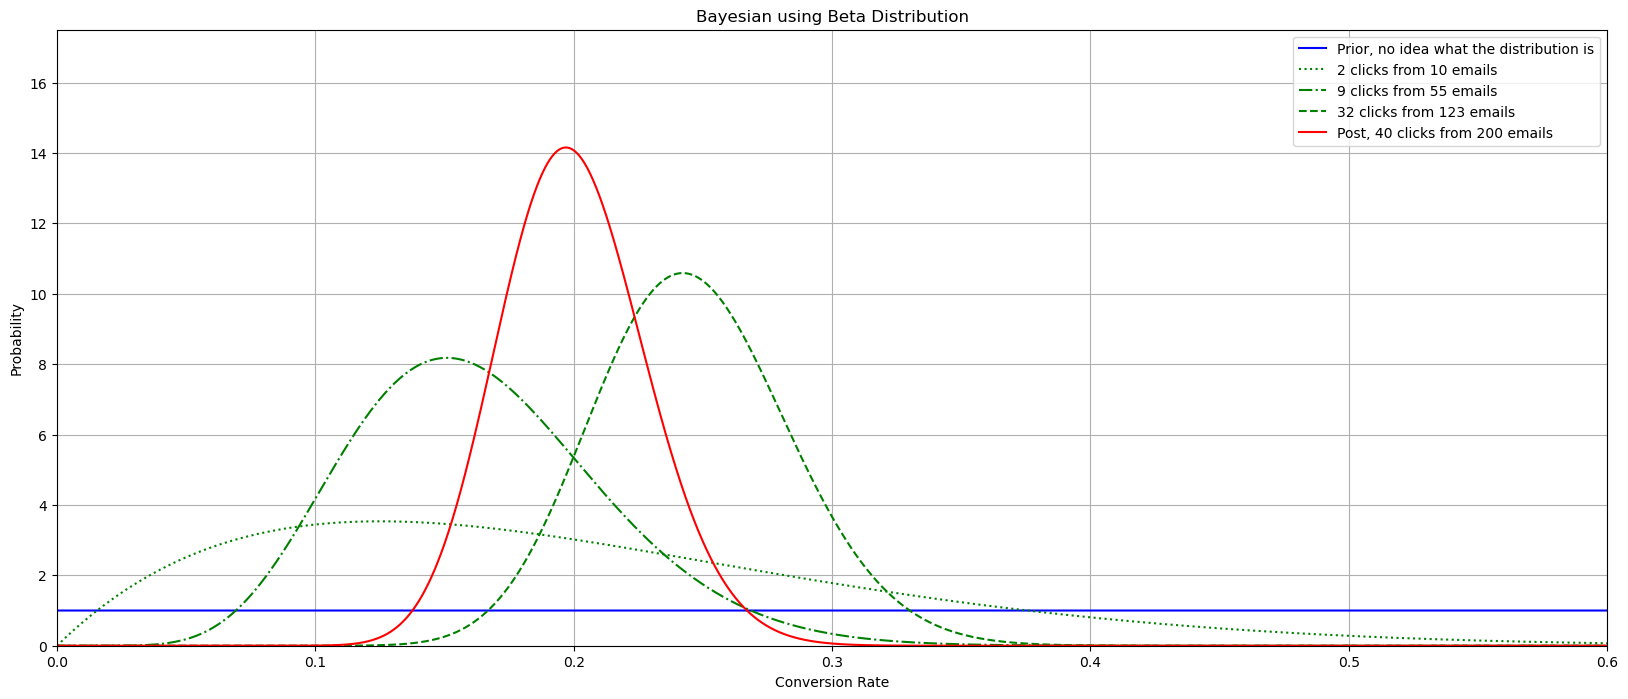

In [94]:
# plot(x,y) --> x is for x-axis 0 to 1
# plot(x,y) --> y is for beta distribution, beta(x,a,b) --> 
# x = interval of values 5k between 0 to 1
# alpha = conversions
# beta = non-conversions

print("Start with a prior distribution - as you gather more data, you update this distribution to a post distribution.")

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(np.linspace(0, 1, 5000), stats.beta.pdf(np.linspace(0, 1, 5000), 1, 1), 'b', label="Prior, no idea what the distribution is")
ax.plot(np.linspace(0, 1, 5000), stats.beta.pdf(np.linspace(0, 1, 5000), 2, 10-2), 'g:', label="2 clicks from 10 emails")
ax.plot(np.linspace(0, 1, 5000), stats.beta.pdf(np.linspace(0, 1, 5000), 9, 55-9), 'g-.', label="9 clicks from 55 emails")
ax.plot(np.linspace(0, 1, 5000), stats.beta.pdf(np.linspace(0, 1, 5000), 32, 123-25), 'g--', label="32 clicks from 123 emails")
ax.plot(np.linspace(0, 1, 5000), stats.beta.pdf(np.linspace(0, 1, 5000), 40, 200-40), 'r-', label="Post, 40 clicks from 200 emails")

ax.plot()
plt.xlim(0,.6)
plt.ylim(0,17.5)
plt.legend()
plt.grid()
plt.title("Bayesian using Beta Distribution")
plt.xlabel("Conversion Rate"); plt.ylabel("Probability");


Start with a prior distribution - as you gather more data, you update this distribution to a post distribution.


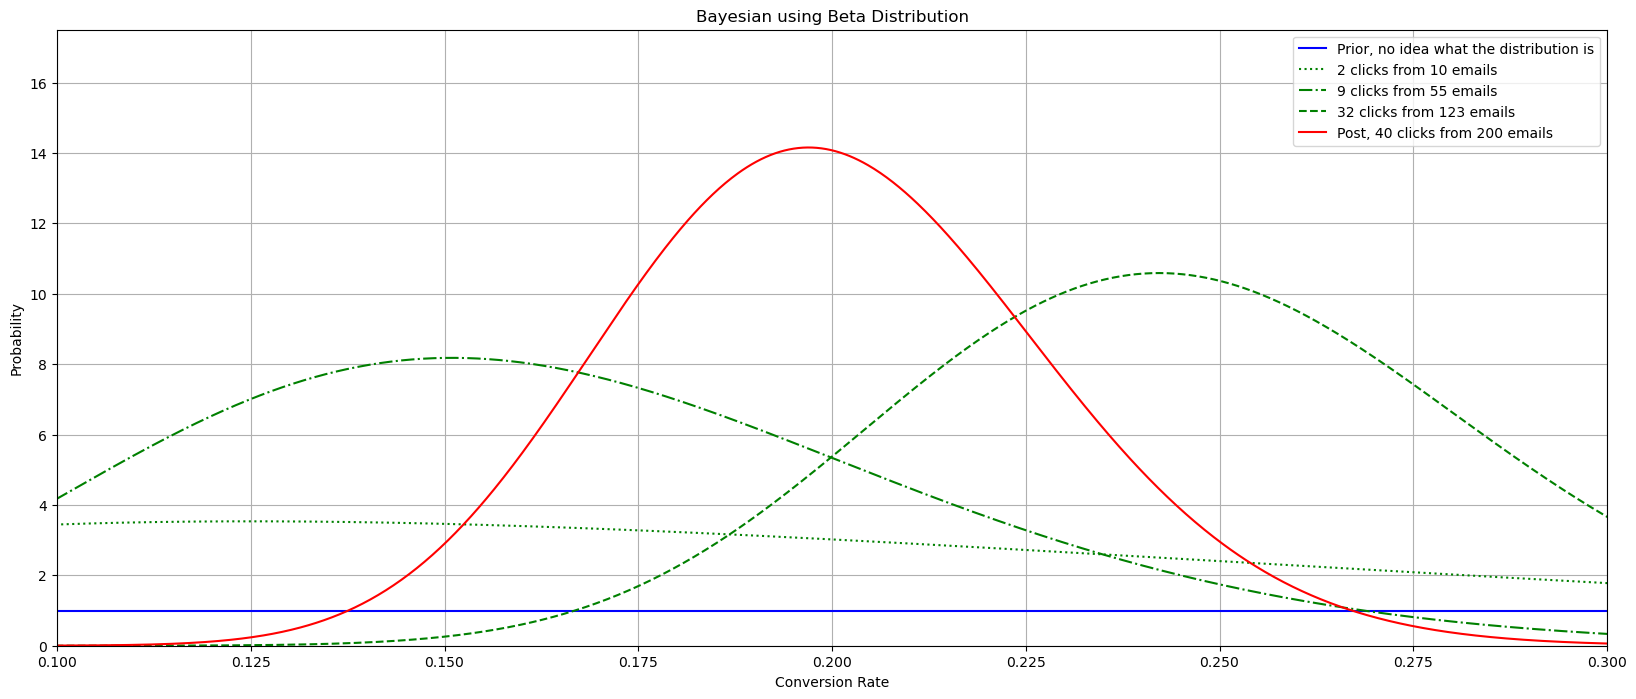

In [95]:
# plot(x,y) --> x is for x-axis 0 to 1
# plot(x,y) --> y is for beta distribution, beta(x,a,b) --> 
# x = interval of values 5k between 0 to 1
# alpha = conversions
# beta = non-conversions

print("Start with a prior distribution - as you gather more data, you update this distribution to a post distribution.")

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(np.linspace(0, 1, 5000), stats.beta.pdf(np.linspace(0, 1, 5000), 1, 1), 'b', label="Prior, no idea what the distribution is")
ax.plot(np.linspace(0, 1, 5000), stats.beta.pdf(np.linspace(0, 1, 5000), 2, 10-2), 'g:', label="2 clicks from 10 emails")
ax.plot(np.linspace(0, 1, 5000), stats.beta.pdf(np.linspace(0, 1, 5000), 9, 55-9), 'g-.', label="9 clicks from 55 emails")
ax.plot(np.linspace(0, 1, 5000), stats.beta.pdf(np.linspace(0, 1, 5000), 32, 123-25), 'g--', label="32 clicks from 123 emails")
ax.plot(np.linspace(0, 1, 5000), stats.beta.pdf(np.linspace(0, 1, 5000), 40, 200-40), 'r-', label="Post, 40 clicks from 200 emails")

ax.plot()
plt.xlim(0.1,.3)
plt.ylim(0,17.5)
plt.legend()
plt.grid()
plt.title("Bayesian using Beta Distribution")
plt.xlabel("Conversion Rate"); plt.ylabel("Probability");
